In [291]:
import networkx as nx
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

## Define the helper functions for Degree Controlled Sampling
We are here using the approach developped in https://www.nature.com/articles/ncomms10331 by Barabasi et al 

It works as follows:
1. Create bins for the PPI network of min(size) >= 100
2. Use the bins to sort nodes from a sub graph into the registered bins from (1)
3. Sample n_i nodes from the PPI, where n_i is the number of nodes from the subgraph in bin_i

This allows for a degree controlled sampling of the main graph, with the caveat that some nodes might never be selected if the subgraph does not contain nodes of all represented degrees.

In [292]:
def make_degree_hist(G, min_bin_size=100):
    degrees = G.degree()
    sorted_G = sorted(degrees, key=lambda deg: deg[1]) 
    hist = []
    bins = []
    tmp = []
    old_deg = 0
    remaining_nodes = len(sorted_G)
    for node, deg in sorted_G:
        if deg != old_deg and len(tmp) >= min_bin_size and remaining_nodes >= min_bin_size:
            hist.append(tmp)
            bins.append(deg)
            old_deg = deg
            tmp = []
        tmp.append(node)
        remaining_nodes -= 1
    hist.append(tmp)
    bins.append(deg)
    return hist, bins

def bin_seeds(G, seeds, bins):
    hist = [[] for i in bins]
    degrees = G.degree()
    subG = [nd for nd in degrees if nd[0] in seeds]
    sorted_G = sorted(subG, key=lambda deg: deg[1])
    print("Removed: {} seeds due to their absence in the PPI".format(len(seeds) - len(sorted_G)))
    for seed, deg in sorted_G:
        index = np.digitize(deg, bins)
        hist[index].append(seed)
    return hist

def sample(PPI_hist, seeds_hist):
    nodes = []
    hist = [[] for i in PPI_hist]
    for i in range(len(PPI_hist)):
        n = len(seeds_hist[i])
        random_nodes = np.random.choice(PPI_hist[i], n)
        nodes += list(random_nodes)
        hist[i] = random_nodes
    return nodes, hist

## Define the path and load the PPI and seeds files 

In [293]:
datapath = '../Data/'
resultpath = '../Results'
PPI_ID = "2018_08"

In [294]:
G = nx.read_graphml(os.path.join(datapath, 'PPIs', 'PPI_{}.graphml'.format(PPI_ID)))
# G = nx.read_graphml(os.path.join("../../../Data/",'PPI.graphml'))

signaling = pd.read_csv(os.path.join(datapath, 'signaling.csv'))

hipo_ova = pd.read_csv(os.path.join(datapath, 'Screen', 'hipo_ova_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(datapath, 'Screen', 'hipo_fec_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(datapath, 'Screen', 'xRNAi_fec_clean.csv'))

hipo_fec_pred = pd.read_csv(os.path.join(datapath, 'Screen','hipo_fec_clean_pred.csv')) 
hipo_ova_pred = pd.read_csv(os.path.join(datapath, 'Screen','hipo_ova_clean_pred.csv'))
xRNAi_fec_pred = pd.read_csv(os.path.join(datapath, 'Screen','xRNAi_fec_clean_pred.csv'))

## Calculate the mean for all datasets 

In [295]:
# Ovariole number screen
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
mean_ova_gene_pred = hipo_ova_pred.groupby('FbID', as_index=False).mean()

# Hippo RNAi Egg Laying screen
mean_fec_gene = hipo_fec[hipo_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()
mean_fec_gene_pred = hipo_fec_pred[hipo_fec_pred['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

# Egg Laying Screen
mean_xRNAi_gene = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()
mean_xRNAi_gene_pred = xRNAi_fec_pred[xRNAi_fec_pred['Condition'] == 'Sum'].groupby('FbID', as_index=False).mean()

## Define the list of genes that passes threshold cutoff

### Threshold definitions

In [296]:
ova_threshold = 2
eggl_threshold = 5

In [297]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
Zposneg_ova = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
Zposneg_ova = [i for i in Zposneg_ova if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_fec = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_fec = [i for i in Zposneg_fec if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
Zposneg_xRNAi = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
Zposneg_xRNAi = [i for i in Zposneg_xRNAi if 'FBgn' in i]

## Assert that we have the right number of positive candidates

In [298]:
assert(len(Zposneg_ova) == 67)
assert(len(Zposneg_fec) == 59)
assert(len(Zposneg_xRNAi) == 49)

## Let's create the first histogram, which derives from the PPI

In [299]:
PPI_hist, PPI_bins = make_degree_hist(G)

Text(0.5, 1.0, 'Bin size of histogram')

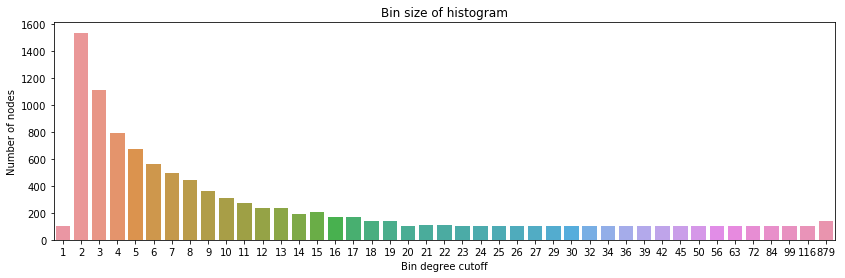

In [300]:
fig = plt.figure(figsize=(14,4))
bin_size = [len(h) for h in PPI_hist]
sns.barplot(PPI_bins, bin_size)
plt.ylabel("Number of nodes")
plt.xlabel("Bin degree cutoff")
plt.title("Bin size of histogram")

In [301]:
seeds = [i for i in mean_fec_gene['FbID'].unique() if i!="Control"]

In [302]:
assert(len(seeds) == 463)

In [303]:
seed_hist = bin_seeds(G, seeds, PPI_bins)

Removed: 23 seeds due to their absence in the PPI


In [304]:
tmp = []
for b in seed_hist:
    tmp += b
assert(len(tmp) == 463-23)

Text(0.5, 1.0, 'Bin size of histogram')

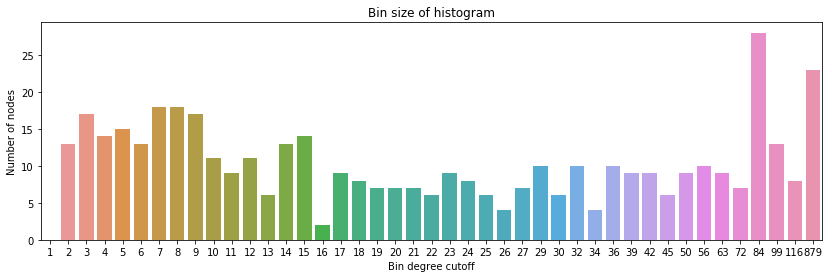

In [305]:
fig = plt.figure(figsize=(14,4))
bin_size = [len(h) for h in seed_hist]
sns.barplot(PPI_bins, bin_size)
plt.ylabel("Number of nodes")
plt.xlabel("Bin degree cutoff")
plt.title("Bin size of histogram")

In [306]:
random_seeds, random_hist = sample(PPI_hist, seed_hist)

In [307]:
assert(len(random_seeds) == len(tmp))

Text(0.5, 1.0, 'Bin size of histogram')

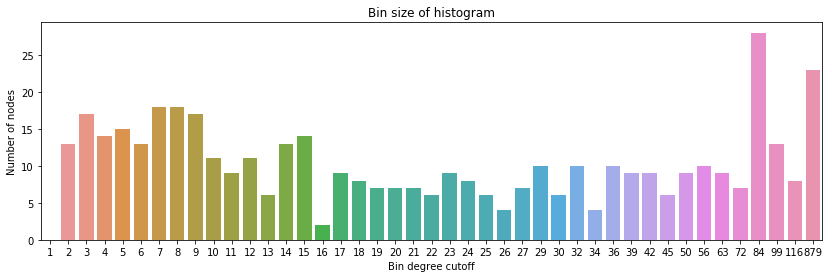

In [308]:
fig = plt.figure(figsize=(14,4))
bin_size = [len(h) for h in random_hist]
sns.barplot(PPI_bins, bin_size)
plt.ylabel("Number of nodes")
plt.xlabel("Bin degree cutoff")
plt.title("Bin size of histogram")

## Now we are going to randomly sample genes and compute the subgraphs properties

In [379]:
# Redifining the helper functions to use the randomly generated modules from 04

def compute_statistics(subG):
    LCC = len(max(nx.connected_components(subG), key=len))
    edges = len(subG.edges())
    density = nx.density(subG)
    avg = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(subG), key=len))
    return [LCC, edges, density, avg]

def compute_random_sample_degree(G, seeds, n=100):
    result = []
    PPI_hist, PPI_bins = make_degree_hist(G)
    seed_hist = bin_seeds(G, seeds, PPI_bins)
    subG = G.subgraph(seeds)
    ground_truth = compute_statistics(subG)
    ground_truth = pd.DataFrame([ground_truth], columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    for i in tqdm(range(n)):
        random_seeds, random_hist = sample(PPI_hist, seed_hist)
        subG = G.subgraph(random_seeds)
        stats = compute_statistics(subG)
        result.append(stats)
    result = pd.DataFrame(result, columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    return result, ground_truth

def compute_random_sample_wholenet(G, seeds, n=100):
    result = []
    nodes = list(G.nodes())
    subG = G.subgraph(seeds)
    ground_truth = compute_statistics(subG)
    ground_truth = pd.DataFrame([ground_truth], columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    for i in tqdm(range(n)):
        random_seeds = np.random.choice(nodes, len(subG.nodes()), replace=False)
        subG = G.subgraph(random_seeds)
        stats = compute_statistics(subG)
        result.append(stats)
    result = pd.DataFrame(result, columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    return result, ground_truth

def compute_stats(G, seeds_list, modules_list, seed, module):
    result_seeds = []
    result_modules = []
    nodes = list(G.nodes())
    subG = G.subgraph(seed)
    ground_truth_seed = compute_statistics(subG)
    ground_truth_seed = pd.DataFrame([ground_truth_seed], columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    
    subG = G.subgraph(module)
    ground_truth_module = compute_statistics(subG)
    ground_truth_module = pd.DataFrame([ground_truth_module], columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    
    for seeds in tqdm(seeds_list):
        subG = G.subgraph(seeds)
        stats = compute_statistics(subG)
        result_seeds.append(stats)
    result_seeds = pd.DataFrame(result_seeds, columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    
    for modules in tqdm(modules_list):
        subG = G.subgraph(modules)
        stats = compute_statistics(subG)
        result_modules.append(stats)
    result_modules = pd.DataFrame(result_modules, columns=["LCC", "EdgeNb", "Density", "AverageShortestPath"])
    
    return result_seeds, result_modules, ground_truth_seed, ground_truth_module

def plot_one(random, ground_truth, metrics=None):
    if not metrics:
        metrics = random.columns
    fig = plt.figure(figsize=(5*len(metrics),5))
    
    for col in range(len(metrics)):
        metric = metrics[col]
        
        ax = fig.add_subplot(1, len(metrics), col+1)

        sns.kdeplot(random[metric], bw=np.std(random[metric]), shade=True, color='lightgray', label="Random bootstrap (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([ground_truth[metric],ground_truth[metric]], [0,top], 'lightcoral', label='Seed Genes (PPI)')

        plt.title('{} of\nselected genes VS random'.format(metric))
        ax.legend().set_visible(False)
        plt.xlabel(metric)
        plt.ylabel('Probability Density')
        plt.xlim(0)
    return fig

def plot_two(random_seeds, random_modules, ground_truth_seed, ground_truth_module, metrics=None):
    if not metrics:
        metrics = random_seeds.columns
    fig = plt.figure(figsize=(2.5*len(metrics),2.5))
    
    for col in range(len(metrics)):
        metric = metrics[col]
        
        ax = fig.add_subplot(1, len(metrics), col+1)

        sns.kdeplot(random_seeds[metric], bw=np.std(random_seeds[metric]), shade=True, color='lightgray', label="Random bootstrap (PPI)")
        sns.kdeplot(random_modules[metric], bw=np.std(random_modules[metric]), shade=True, color='gray', label="Random bootstrap (PPI)")
        
        bot, top = ax.get_ylim()
        plt.plot([ground_truth_seed[metric],ground_truth_seed[metric]], [0, top], 'lightcoral', label='Seed Genes (PPI)')
        plt.plot([ground_truth_module[metric],ground_truth_module[metric]], [0, top], 'darkred', label='Seed Genes (PPI)')

        plt.title('{} of\nselected genes VS random'.format(metric))
        ax.legend().set_visible(False)
        plt.xlabel(metric)
        plt.ylabel('Probability Density')
        plt.xlim(0)
    return fig

## Alright let's create a set of 500 deggree controlled random seeds for each phenotype

In [273]:
def random_sample_degree(G, seeds, n=100):
    result = []
    PPI_hist, PPI_bins = make_degree_hist(G)
    seed_hist = bin_seeds(G, seeds, PPI_bins)
    for i in range(n):
        random_seeds, random_hist = sample(PPI_hist, seed_hist)
        result.append(random_seeds)
    return result

In [274]:
seeds = Zposneg_ova
random_seeds = random_sample_degree(G, seeds)
name = "ova_seeds"
f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'w')
for s in random_seeds:
    f.write(",".join(s) + '\n')
f.close()

Removed: 1 seeds due to their absence in the PPI


In [275]:
seeds = Zposneg_fec
random_seeds = random_sample_degree(G, seeds)
name = "hpoeggl_seeds"
f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'w')
for s in random_seeds:
    f.write(",".join(s) + '\n')
f.close()

Removed: 1 seeds due to their absence in the PPI


In [276]:
seeds = Zposneg_xRNAi
random_seeds = random_sample_degree(G, seeds)
name = "eggl_seeds"
f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'w')
for s in random_seeds:
    f.write(",".join(s) + '\n')
f.close()

Removed: 0 seeds due to their absence in the PPI


In [277]:
seeds = set.intersection(set(Zposneg_ova), set(Zposneg_fec), set(Zposneg_xRNAi))
random_seeds = random_sample_degree(G, seeds)
name = "core_seeds"
f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'w')
for s in random_seeds:
    f.write(",".join(s) + '\n')
f.close()

Removed: 0 seeds due to their absence in the PPI


# Analysis

## Computing the Signaling Screen bias

In [380]:
sns.set()

/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Removed: 23 seeds due to their absence in the PPI


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


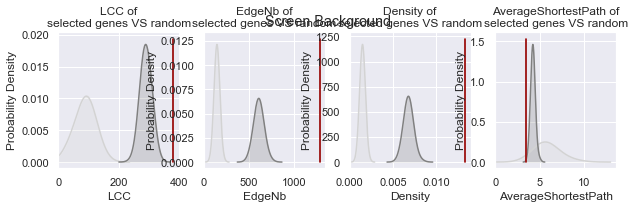

In [381]:
screen_genes = [i for i in mean_fec_gene['FbID'].unique() if i!="Control"]
screen_G = G.subgraph(screen_genes)
stats_net, ground_truth_net = compute_random_sample_wholenet(G, screen_genes)
stats_deg, screen_genes = compute_random_sample_degree(G, screen_genes)
fig = plot_two(stats_net, stats_deg, ground_truth_net, screen_genes)
fig.suptitle("Screen Background")
fig.savefig("../Results/Figures/Net_Metrics_Screen_Bg.svg")

## Now computing for each of the phenotype category

Removed: 1 seeds due to their absence in the PPI


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Removed: 1 seeds due to their absence in the PPI


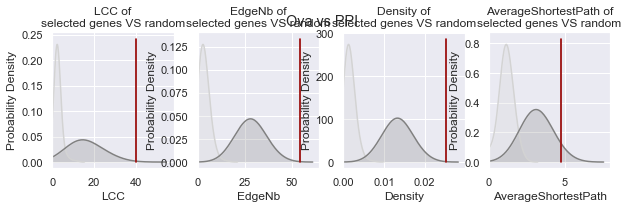

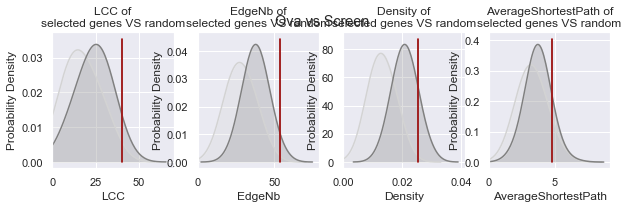

In [383]:
# With PPI as background
seeds = Zposneg_ova
name = "Ova"
stats_deg, ground_truth_deg = compute_random_sample_degree(G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs PPI".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_PPI.svg".format(name))

# With Screened genes as background

stats_deg, ground_truth_deg = compute_random_sample_degree(screen_G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(screen_G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs Screen".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Screen.svg".format(name))

Removed: 1 seeds due to their absence in the PPI


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Removed: 1 seeds due to their absence in the PPI


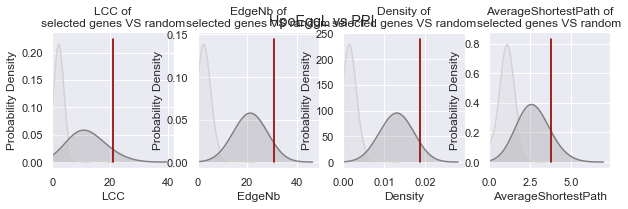

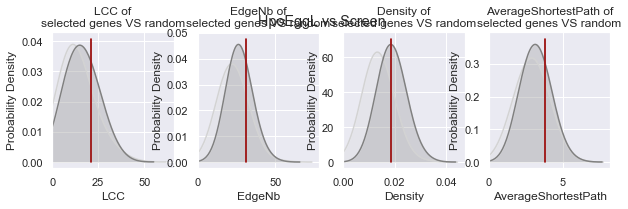

In [384]:
# With PPI as background
seeds = Zposneg_fec
name = "HpoEggL"
stats_deg, ground_truth_deg = compute_random_sample_degree(G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs PPI".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_PPI.svg".format(name))

# With Screened genes as background

stats_deg, ground_truth_deg = compute_random_sample_degree(screen_G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(screen_G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs Screen".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Screen.svg".format(name))

Removed: 0 seeds due to their absence in the PPI


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Removed: 0 seeds due to their absence in the PPI


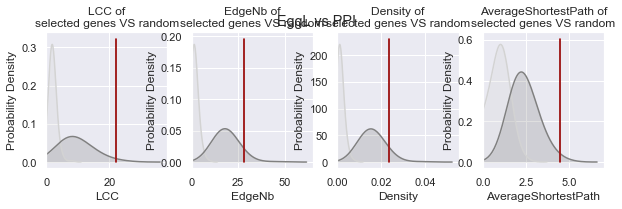

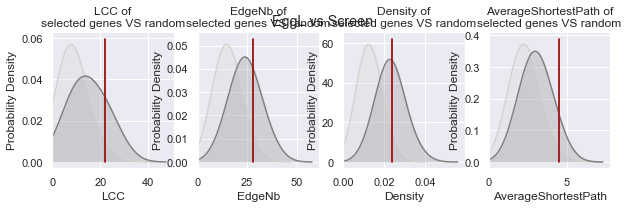

In [385]:
# With PPI as background
seeds = Zposneg_xRNAi
name = "EggL"
stats_deg, ground_truth_deg = compute_random_sample_degree(G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs PPI".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_PPI.svg".format(name))

# With Screened genes as background

stats_deg, ground_truth_deg = compute_random_sample_degree(screen_G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(screen_G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs Screen".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Screen.svg".format(name))

Removed: 0 seeds due to their absence in the PPI


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Removed: 0 seeds due to their absence in the PPI


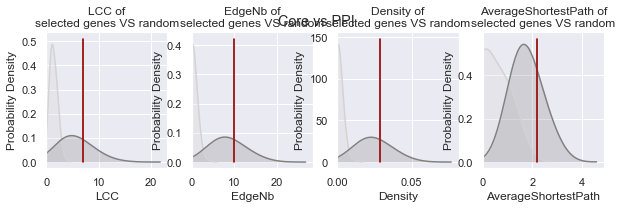

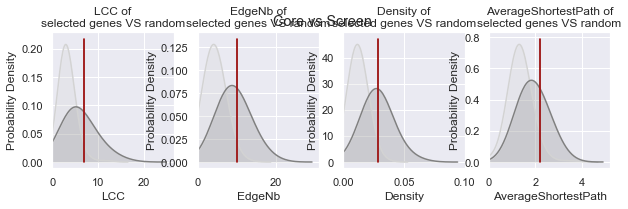

In [386]:
# With PPI as background
seeds = set.intersection(set(Zposneg_ova), set(Zposneg_fec), set(Zposneg_xRNAi))
name = "Core"
stats_deg, ground_truth_deg = compute_random_sample_degree(G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs PPI".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_PPI.svg".format(name))

# With Screened genes as background

stats_deg, ground_truth_deg = compute_random_sample_degree(screen_G, seeds)
stats_net, ground_truth_net = compute_random_sample_wholenet(screen_G, seeds)

fig = plot_two(stats_net, stats_deg, ground_truth_net, ground_truth_deg)
fig.suptitle("{} vs Screen".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Screen.svg".format(name))

# Now let's do the Modules

We are using two different type of modules here:
- Take a random sample of size n=len(module) -> Run the SCA
- Take a Degree controlled random sample of size n=len(module) -> Run the SCA

In [387]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module_{}.graphml'.format(PPI_ID)))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module_{}.graphml'.format(PPI_ID)))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module_{}.graphml'.format(PPI_ID)))

/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


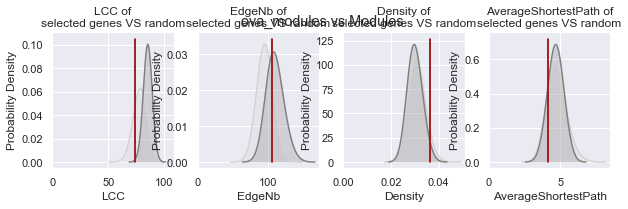

In [367]:
name = "ova_modules"
module = ova_module_G.nodes()

f = open("../Results/SCA_Random_Sampling/" + name, 'r')
random_list = [i.strip().split(',') for i in f.readlines()]

f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'r')
deg_ctrl_list = [i.strip().split(',') for i in f.readlines()]

result_seeds, result_modules, ground_truth_seed, ground_truth_module = compute_stats(G, random_list, deg_ctrl_list, module, module)
fig = plot_two(result_seeds, result_modules, ground_truth_seed, ground_truth_module)

fig.suptitle("{} vs Modules".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Modules.svg".format(name))

/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


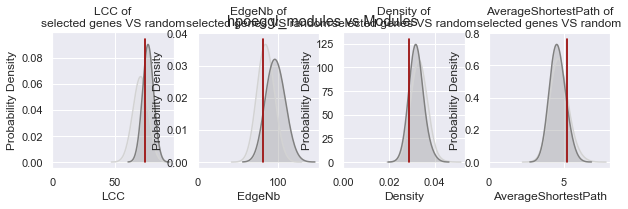

In [368]:
name = "hpoeggl_modules"
module = fec_module_G.nodes()

f = open("../Results/SCA_Random_Sampling/" + name, 'r')
random_list = [i.strip().split(',') for i in f.readlines()]

f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'r')
deg_ctrl_list = [i.strip().split(',') for i in f.readlines()]

result_seeds, result_modules, ground_truth_seed, ground_truth_module = compute_stats(G, random_list, deg_ctrl_list, module, module)
fig = plot_two(result_seeds, result_modules, ground_truth_seed, ground_truth_module)

fig.suptitle("{} vs Modules".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Modules.svg".format(name))

/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


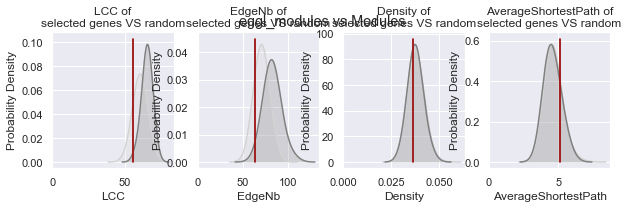

In [369]:
name = "eggl_modules"
module = xRNAi_module_G.nodes()

f = open("../Results/SCA_Random_Sampling/" + name, 'r')
random_list = [i.strip().split(',') for i in f.readlines()]

f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'r')
deg_ctrl_list = [i.strip().split(',') for i in f.readlines()]

result_seeds, result_modules, ground_truth_seed, ground_truth_module = compute_stats(G, random_list, deg_ctrl_list, module, module)
fig = plot_two(result_seeds, result_modules, ground_truth_seed, ground_truth_module)

fig.suptitle("{} vs Modules".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Modules.svg".format(name))

/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/lblondel/anaconda3/envs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


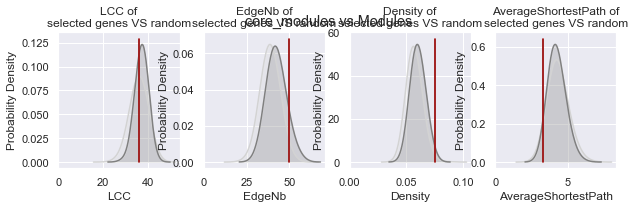

In [370]:
name = "core_modules"
module = core_module_G.nodes()

f = open("../Results/SCA_Random_Sampling/" + name, 'r')
random_list = [i.strip().split(',') for i in f.readlines()]

f = open("../Results/SCA_Random_Sampling/Degree_Controlled/" + name, 'r')
deg_ctrl_list = [i.strip().split(',') for i in f.readlines()]

result_seeds, result_modules, ground_truth_seed, ground_truth_module = compute_stats(G, random_list, deg_ctrl_list, module, module)
fig = plot_two(result_seeds, result_modules, ground_truth_seed, ground_truth_module)

fig.suptitle("{} vs Modules".format(name))
fig.savefig("../Results/Figures/Net_Metrics_{}_vs_Modules.svg".format(name))